In [288]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import cftime
from glob import glob
import cmocean

# Parameters for the C budget
c_2_n = 106 / 16
iron_molar_weight = 55.8
seconds_per_year = 24*60*60*365

## Generate paths

In [289]:
# pp path
pp_path = '/archive/jyl/fre/ESM45/ESM45_COBALTv3_20250224/ESM4.5v02cobv3_piC/gfdl.ncrc5-intel23-prod-openmp/pp/'
#pp_path = '/archive/jyl/fre/ESM45/ESM45_COBALTv3_20250227/ESM4.5v06_om5b08_cobv3_meke_final_piC/gfdl.ncrc5-intel23-prod-openmp/pp/'
#pp_path = '/archive/jyl/fre/OM4_05/pull_requests/2025_02/OM4_05_COBALTv3_jra55_const/gfdl.ncrc5-intel23-prod/pp/'

In [290]:
grid_file = pp_path + 'ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

In [291]:
# carbon vertical integral 
diag_type = 'ocean_cobalt_tracers_instant'
variable = 'wc_vert_int_fe'

total_vertint_files = glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + variable + '.nc')

In [292]:
# iron flux files
# surface fluxes
diag_type = 'ocean_cobalt_sfc'
variables = ['dep_dry_fed','dep_wet_fed','runoff_flux_fed','ffe_iceberg']

surf_files = [glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + v + '.nc') for v in variables]
surf_files = sorted([f for fi in surf_files for f in fi]) # nested list comprehension

In [293]:
# iron flux files
# bottom fluxes
diag_type = 'ocean_cobalt_btm'
# variables = ['ffe_sed','ffetot_btm','ffe_geotherm','ffedet_btm',\
#              'ffedet_btm','ffesm_btm','ffemd_btm','ffelg_btm']
variables = ['ffe_sed','ffetot_btm','ffe_geotherm']

btm_files = [glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + v + '.nc') for v in variables]
btm_files = sorted([f for fi in btm_files for f in fi]) # nested list comprehension
btm_files

['/archive/jyl/fre/ESM45/ESM45_COBALTv3_20250224/ESM4.5v02cobv3_piC/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_cobalt_btm/ts/annual/5yr/ocean_cobalt_btm.0001-0005.ffe_geotherm.nc',
 '/archive/jyl/fre/ESM45/ESM45_COBALTv3_20250224/ESM4.5v02cobv3_piC/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_cobalt_btm/ts/annual/5yr/ocean_cobalt_btm.0001-0005.ffe_sed.nc',
 '/archive/jyl/fre/ESM45/ESM45_COBALTv3_20250224/ESM4.5v02cobv3_piC/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_cobalt_btm/ts/annual/5yr/ocean_cobalt_btm.0001-0005.ffetot_btm.nc',
 '/archive/jyl/fre/ESM45/ESM45_COBALTv3_20250224/ESM4.5v02cobv3_piC/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_cobalt_btm/ts/annual/5yr/ocean_cobalt_btm.0006-0010.ffe_geotherm.nc',
 '/archive/jyl/fre/ESM45/ESM45_COBALTv3_20250224/ESM4.5v02cobv3_piC/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_cobalt_btm/ts/annual/5yr/ocean_cobalt_btm.0006-0010.ffe_sed.nc',
 '/archive/jyl/fre/ESM45/ESM45_COBALTv3_20250224/ESM4.5v02cobv3_piC/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_cobalt_btm/ts/

## Read in files

In [294]:
total = xr.open_mfdataset(total_vertint_files, combine='by_coords')

In [295]:
surf = xr.open_mfdataset(surf_files, combine='by_coords')

In [296]:
btm = xr.open_mfdataset(btm_files, combine='by_coords')

## Compute Global Inventory
These values are from ocean_cobalt_tracer_instant and are written out at the end of the year

In [297]:
global_total = (total.wc_vert_int_fe * grid.areacello).sum(dim=['xh','yh']) * iron_molar_weight

Text(0.5, 1.0, 'Global iron inventory (Tg)')

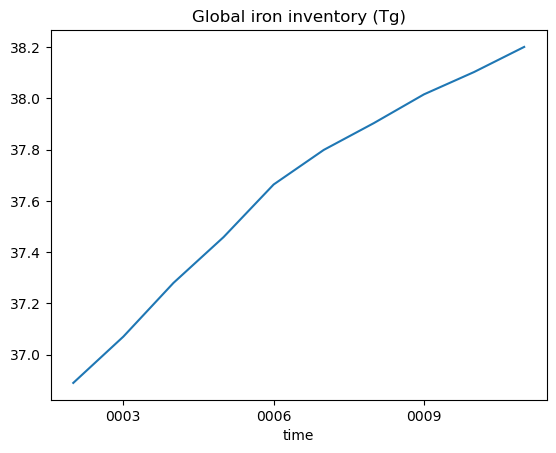

In [298]:
(global_total/1e12).plot()
plt.title('Global iron inventory (Tg)')

## Compute Fluxes

In [300]:
total_deposition = surf.dep_dry_fed + surf.dep_wet_fed

total_deposition = (total_deposition * grid.areacello).sum(dim=['xh','yh'])
total_deposition = total_deposition * iron_molar_weight * seconds_per_year

In [301]:
runoff = (surf.runoff_flux_fed * grid.areacello).sum(dim=['xh','yh'])
runoff = runoff * iron_molar_weight * seconds_per_year

In [302]:
icebergs = (surf.ffe_iceberg * grid.areacello).sum(dim=['xh','yh'])
icebergs = icebergs * iron_molar_weight * seconds_per_year

In [303]:
sediments = (btm.ffe_sed * grid.areacello).sum(dim=['xh','yh'])
sediments = sediments * iron_molar_weight * seconds_per_year

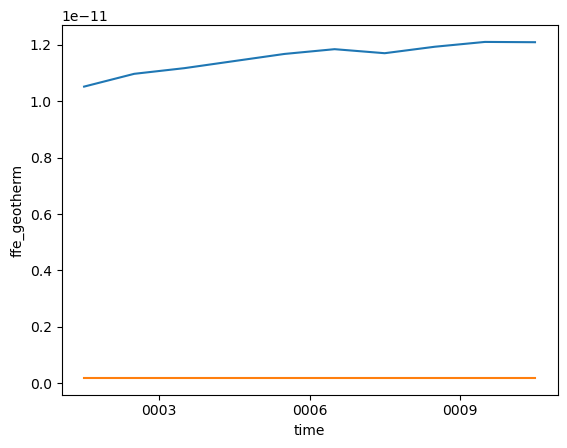

In [304]:
btm.ffe_sed.mean(dim=['xh','yh']).plot()
btm.ffe_geotherm.mean(dim=['xh','yh']).plot()

In [305]:
geothermal = (btm.ffe_geotherm * grid.areacello).sum(dim=['xh','yh'])
geothermal = geothermal * iron_molar_weight * seconds_per_year

In [306]:
burial = (btm.ffetot_btm * grid.areacello).sum(dim=['xh','yh'])
#burial = ((btm.ffedet_btm + btm.ffesm_btm + btm.ffemd_btm + btm.ffelg_btm) * grid.areacello).sum(dim=['xh','yh'])

burial = burial * iron_molar_weight * seconds_per_year

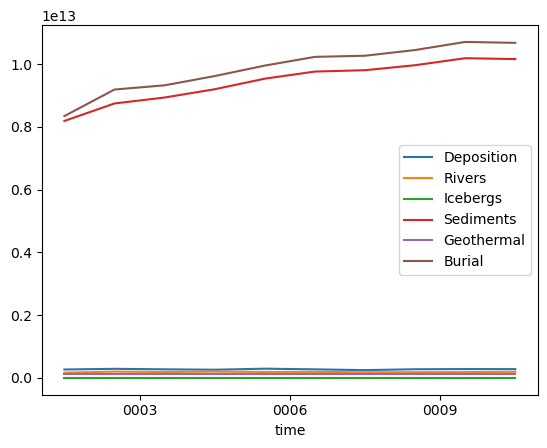

In [315]:
total_deposition.plot()
runoff.plot()
icebergs.plot()
sediments.plot()
geothermal.plot()
burial.plot()
plt.legend(['Deposition','Rivers','Icebergs','Sediments','Geothermal','Burial'])

Text(0.5, 1.0, 'Net iron fluxes (grams)')

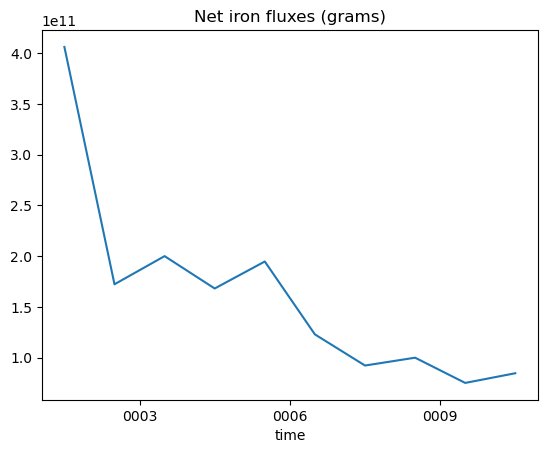

In [308]:
net_flux = total_deposition + icebergs + runoff + sediments + geothermal - burial
(net_flux).plot()
plt.title('Net iron fluxes (grams)')

## Close budgets
The total iron inventory should be equal to the starting inventory plus the iron fluxes
In this case we start with year 2 and onwards, because the wc_vert_int_fe term is saved at the end of year 1
One complication is that the sedimentary 

Text(0.5, 1.0, 'Iron fluxes as calculated by the change in the global Fe inventory')

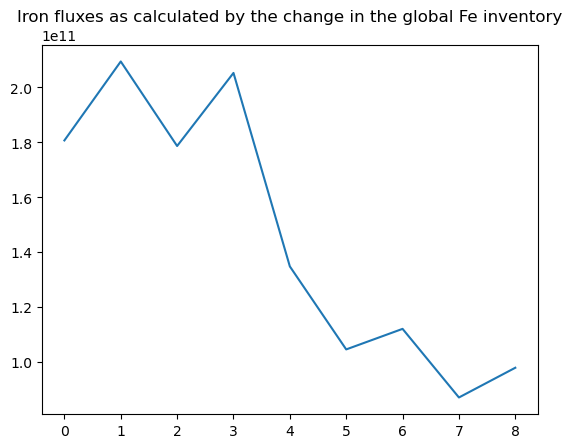

In [309]:
plt.plot(np.diff(global_total))
plt.title('Iron fluxes as calculated by the change in the global Fe inventory')

In [310]:
np.diff(global_total.values)

array([1.8066545e+11, 2.0941321e+11, 1.7863960e+11, 2.0524407e+11,
       1.3480074e+11, 1.0458497e+11, 1.1206761e+11, 8.7086334e+10,
       9.7911833e+10], dtype=float32)

In [311]:
net_flux.values[1:]

array([1.72326740e+11, 2.00045113e+11, 1.68178893e+11, 1.94750807e+11,
       1.22998153e+11, 9.23377237e+10, 1.00054389e+11, 7.52125516e+10,
       8.47452007e+10])

Text(0.5, 1.0, 'Global Fe inventory (g)')

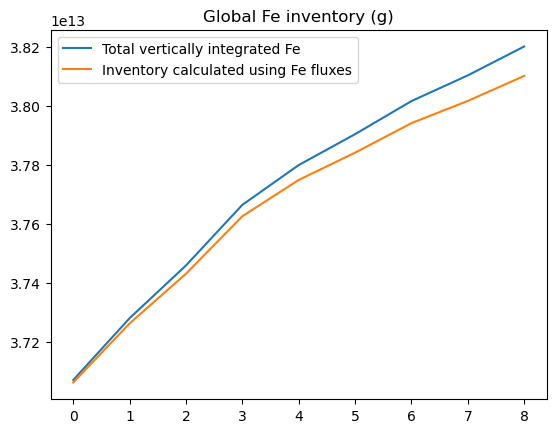

In [312]:
plt.plot(global_total.values[1:])
plt.plot((np.cumsum(net_flux.values[1:])+global_total.values[0]))
#plt.ylim(37.94,37.948)
plt.legend(['Total vertically integrated Fe','Inventory calculated using Fe fluxes'])
plt.title('Global Fe inventory (g)')

Text(0.5, 1.0, 'Total global iron inventory imbalance')

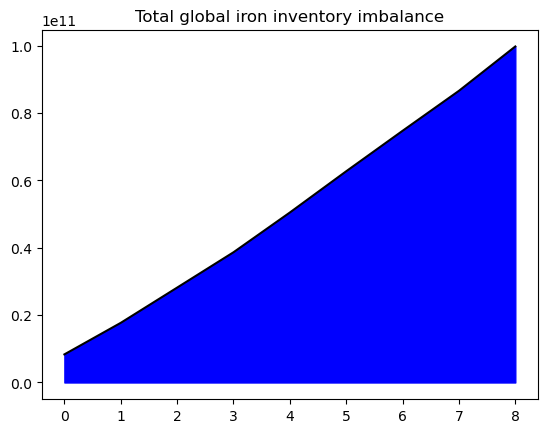

In [313]:
fig,ax = plt.subplots(1,1)
imbalance=(global_total.values[1:] - (np.cumsum(net_flux.values[1:])+global_total.values[0]))
plt.plot(imbalance, color='black')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance>0, interpolate=True, color='blue')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance<0, interpolate=True, color='red')
plt.title('Total global iron inventory imbalance')

Text(0.5, 1.0, 'Total global iron budget imbalance')

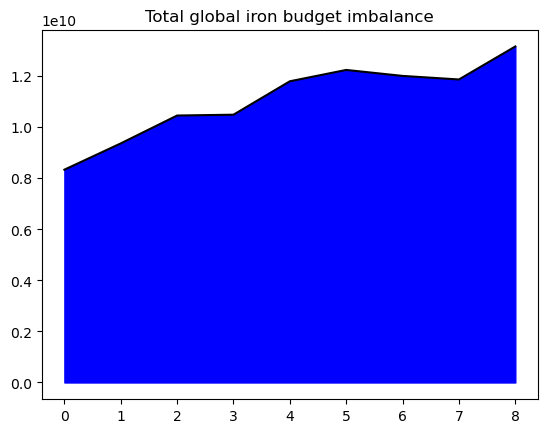

In [314]:
fig,ax = plt.subplots(1,1)
imbalance=(np.diff(global_total.values) - net_flux.values[1:])
plt.plot(imbalance, color='black')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance>0, interpolate=True, color='blue')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance<0, interpolate=True, color='red')
plt.title('Total global iron budget imbalance')